# Selection of genes for formation of regulons

In order to reduce the number of genes used for regulon calculation only genes with close neighbours are included. Based on previously perfomed network visualisation it is evident that mojority of genes are located within furballs of tightly connected genes, meaning that having one closely related neighbour often means having multiple (e.g. networks included all gene pairs with similarity above certain threshold, based on calculation of larger number of neighbours for each gene (e.g 200)).

To find genes with close neighbours the closest neighbour is calculated for each gene. Only genes from gene pairs with similarity above selected "threshold" (cosine similarity) are retained. The similarity calculation is based on data preprocessed with: log transformation and scaling each gene from 0 to 1 to remove effect of expression strength on similarity computation. The selection of log transformation and scaling method is justified below.

Genes with at least one close neighbopur are selected since Gadi requested retention of regulons of all sizes (e.g. even regulons comprised of 2 tightly connected genes). For each gene 2 closest neighbour are computed. This must be done as when profiles are not inversed, one of the 2 closest neighbours will be self and thus automatically excluded from determining if a gene has a close neighbour. 

The selection of similarity threshold can be done based on N of retained genes at this threshold or comparison of retained genes between data subsets, each containing only part of measurments (features).

## Load data

In [79]:
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import random

from correlation_enrichment.library import SimilarityCalculator
import library_regulons
importlib.reload(library_regulons)
from library_regulons import *
import jupyter_functions as jf
importlib.reload(jf)
import jupyter_functions as jf


In [ ]:
dataPath=module_path+'/data_expression/'
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [30]:
neighbour_calculator = NeighbourCalculator(genes,conditions=conditions,conditions_names_column='Measurment')

# Parameter selection

To determine which parameters are most reliable data is subseted in 2 parts and results computed on both of them are compared. Currently this is done based on replicates: part of replicates (and their time points) is used as training set and the other as test set of features.

Curent data has 49 replicates, 25 of which are used in traingng (subset1) and other 24 in testing (subset2).

In [4]:
available_replicates=list(set(conditions.loc[:,'Replicate']))
print('N of replicates:',len(available_replicates))

N of replicates: 49


In [27]:
subset1,subset2=jf.sample_from_list(available_replicates,sample1=25)

In [28]:
print('Subset1:\n',', '.join(subset1),'\n')
print('Subset2:\n',', '.join(subset2))

Subset1:
 gtaG_r1, AX4_bio1, mybB_bio1, comH_r2, gtaC_r27B, amiB_r2, cudA_r3, ac3pkaCoe_r2, gtaI_bio1, tgrB1_r2, mybBGFP_bio2, AX4_r2, pkaCoeAX4_r2, acaA_bio2, gtaC_r41A, dgcA_r2, AX4_bio3, gtaC_r21A, mybB_bio2, cudA_r2, tagB_bio2, ecmA_bio2, pkaR_bio1, gtaG_r2, AX4_r1 

Subset2:
 ac3pkaCoe_r1, ecmA_bio1, AX4_FDpool01, comH_r1, dgcA_r1, pkaR_bio2, AX4_bio2, pkaCoeAX4_r3, tgrB1C1_r2, gtaC_r47B, AX4_pool21, tgrC1_r2, gbfA_r3, mybBGFP_bio1, tgrB1C1_r1, amiB_r1, AX4_FDpool02, acaA_bio1, tagB_bio1, gbfA_r1, tgrC1_r1, tgrB1_r1, AX4_pool19, gtaI_bio2


## Data preprocessing parameters selection

To select how data should be preprocessed it was compared how data log transformation vs no transformation and scaling from 0 to 1 (minmax) or to mean=0 and std=1 (mean0std1) affect the reliability of result across random sample of replicates.


The below table shows:
- N neighbours - N of neighbours computed for each gene.
- inverse - If False most similar neighbour, if True neighbour with most similar inversed profile (multiplied by -1 before scaling).
- use_log - Was data log transformed before scaling.
- scale - mean0std1: mean=0, std=1; minmax: from 0 to 1
- threshold - Cosine similarity threshold used. Pairs below it were excluded from calculations (MSE, N pairs, N genes, F value).
- batches - Currently not used. Could be used if similarity calculation was done for each strain separately, later using only gene pairs highly associted in all individual strains.
- MSE - For evaluation of similarity results. Difference between similarity in training and test set. SE=(similarity_training-similarity_test)^2  This is done for all neighbour pairs retained after similarity filtering in the training set, averaging SEs to obtain MSE. Training similarities are used as extracted from the closest neighbours computation library; similarities in test set are computed 'by hand'. It was previoulsy tested that these similarities correspond.
- N pairs - N of gene pairs retained in training sample after filtering with specified threshold.
- N genes - N of genes retained in training sample after filtering with specified threshold.
- F value - For evaluation of N of retained genes. Similar to recall and accuracy based F value, but as there is no knowledge about 'real truth' it is computed as follows: Neighbours are obtained both for training and test set. Pairs are filtered and genes in remaining pairs are selected. TP = genes present in both training and test set after filtering, FN_training = genes present only in test set after filtering, FN_test = genes present only in training set after filtering. r_test=TP/(TP+FN_test) and r_train=TP/(TP+FN_training). F=2 * r_test * r_training/(r_test+r_training)

Table is sorted by F value. Larger F value at similar number of retained genes shows that there is greater consistency between subsets, thus the metric seems to beter select true associations.

In [31]:
#Make table of results for different condition settings
results=[]
#Which parameters to try
#thresholds=[0.95]
thresholds=[0.93,0.94,0.95,0.97,0.991,0.992,0.993]
for scale in ['minmax','mean0std1']:
    for use_log in [True,False]:
            for inverse in [False]:
                for n_neighbours in [2]:
                    result = neighbour_calculator.compare_conditions(
                                        # Parameters
                                        neighbours_n=n_neighbours, inverse=inverse, scale=scale, use_log=use_log,
                                        thresholds=thresholds, 
                                        filter_column='Replicate',
                                        #For subset genes
                                        filter_column_values_sub=subset1,
                                        #For test genes
                                        filter_column_values_test=subset2, 
                                                
                                        batch_column=None,retained=[1000,1500])
                    for res in result:
                        results.append(res)
data_summary_params=pd.DataFrame(results)

/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


In [34]:
data_summary_params.sort_values(by='F value',ascending=False)

,N neighbours,inverse,use_log,scale,threshold,batches,MSE,N pairs,N genes,F value
2,2,False,True,mean0std1,0.940,None,0.00377,989,1235,0.809626
0,2,False,True,minmax,0.991,None,0.00358,1123,1360,0.748522
3,2,False,False,mean0std1,0.940,None,0.01210,893,1244,0.705093
1,2,False,False,minmax,0.970,None,0.00795,801,1151,0.664516


For inverse neighbours. Range of obtained neighbours is set to smaller number as it was previously determined that there seem to be less good inverse neighbours.

In [87]:
results_inv=[]
#Which parameters to try
thresholds=[0.73,0.84,0.964,0.986,0.987,0.99]
for scale in ['minmax','mean0std1']:
    for use_log in [True,False]:
            for inverse in [True]:
                for n_neighbours in [2]:
                    result = neighbour_calculator.compare_conditions(
                                        # Parameters
                                        neighbours_n=n_neighbours, inverse=inverse, scale=scale, use_log=use_log,
                                        thresholds=thresholds, 
                                        filter_column='Replicate',
                                        #For subset genes
                                        filter_column_values_sub=subset1,
                                        #For test genes
                                        filter_column_values_test=subset2, 
                                                
                                        batch_column=None,retained=[400,600])
                    for res in result:
                        results_inv.append(res)
data_summary_params_inv=pd.DataFrame(results_inv)

/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


In [88]:
data_summary_params_inv

,N neighbours,inverse,use_log,scale,threshold,batches,MSE,N pairs,N genes,F value
0,2,True,True,minmax,0.986,None,0.05094,815,558,0.502006
1,2,True,False,minmax,0.964,None,0.06212,490,429,0.461373
2,2,True,True,mean0std1,0.840,None,0.00257,821,564,0.609959
3,2,True,False,mean0std1,0.730,None,0.01157,858,521,0.546379


Preprocessing with log2 transformation and scaling with to mean 0 and std 1 gives most reliable results when comparing different combinations of parameter with retained genes (this is different for MSE, which is probably affected by scale of similarities of different methods).

## Necesary number of calculated neighbours to reliabli get genes with close neighbours

Algorithem used for neighbour calculation is stohastic. When comparing number of gene pairs above certain threshold, even when using high threshold (e.g. 0.99) there will be some pairs missed if only a few tens of closest neighbours are computed instead of a few hundreds of closest neighbours (shown in notebook regulons). Thus calculationg only 2 neighbours to find genes that have at least one close neighbour at ceratin threshold could lead to false negatives. However, calculating more neighbours can drasticaly increase compute time. 

Thus it was evaluated how the number of computed neighbours affects the set of retained genes. Genes retained when using more neighbours (100, termed 'larger') are compared to set of genes retained when computing less neighbours (2,3,5,10, termed 'smaller') at different thresholds. Using small number of neighbours seems to be sufficnet as only a small proportion of genes is missed. 
Intersect: presenet in smaller and larger, unique_larger: would be missed.

Processing with minmax and log.

In [9]:
jf.obtained_genes_by_n_neighbours(neighbour_calculator=neighbour_calculator, neighbours_size_larger=100,
                                   neighbours_sizes_smaller=[2,3,5,10], thresholds=[0.95,0.98,0.99],log=True)

,n_neighbours,threshold,intersect,unique_smaller,unique_larger
0,2,0.95,9016,0,4
1,2,0.98,5450,0,0
2,2,0.99,1936,0,0
3,3,0.95,9020,0,0
4,3,0.98,5450,0,0
5,3,0.99,1936,0,0
6,5,0.95,9019,0,1
7,5,0.98,5450,0,0
8,5,0.99,1936,0,0
9,10,0.95,9019,0,1


Processing with minmax without log.

In [12]:
jf.obtained_genes_by_n_neighbours(neighbour_calculator=neighbour_calculator, neighbours_size_larger=100,
                                   neighbours_sizes_smaller=[2,3,5,10], thresholds=[0.95,0.98,0.99],log=False)

,n_neighbours,threshold,intersect,unique_smaller,unique_larger
0,2,0.95,3593,0,10
1,2,0.98,310,0,4
2,2,0.99,38,0,0
3,3,0.95,3601,0,2
4,3,0.98,311,0,3
5,3,0.99,38,0,0
6,5,0.95,3596,0,7
7,5,0.98,309,0,5
8,5,0.99,38,0,0
9,10,0.95,3601,0,2


In [80]:
jf.obtained_genes_by_n_neighbours(neighbour_calculator=neighbour_calculator, neighbours_size_larger=100,
                                   neighbours_sizes_smaller=[2,3,5,10], thresholds=[0.95,0.98,0.99],scale='mean0std1')

,n_neighbours,threshold,intersect,unique_smaller,unique_larger
0,2,0.95,780,0,4
1,2,0.98,76,0,2
2,2,0.99,8,0,0
3,3,0.95,784,0,0
4,3,0.98,78,0,0
5,3,0.99,8,0,0
6,5,0.95,784,0,0
7,5,0.98,78,0,0
8,5,0.99,8,0,0
9,10,0.95,784,0,0


## Similarity threshold selection

To determine which genes will be retained for regulon computation it must be selected how close must be the nearest neighbour to preserve the genes from this pair. 

This could be done based on N of retained genes at each threshold (N genes) or by comparison of retained gene sets between samples (variation of F value), as done above for preprocessing parameter selection. The table is as above, subseted by relevant columns.

A 'bump' sometimes appears at higher thresholds, posslibly indicating variability between replicates (used in training/test set) that becomes evident at lower number of retained genes. This variability between strains can be evaluated latter when plotting the expression profiles.

Scaling with minmax and use of log transformation.

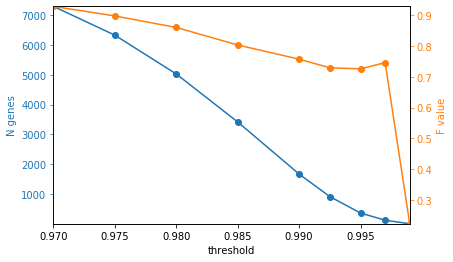

In [37]:
summary=neighbour_calculator.plot_select_threshold(thresholds=[0.97,0.975,0.98,0.985,0.99,0.9925,0.995,0.997,0.999],
                                                   filter_column='Replicate',
                                                   filter_column_values_sub=subset1,
                                                   filter_column_values_test=subset2,
                                                   neighbours_n=2)

In [38]:
summary.loc[:,['threshold','N genes','F value']]

,threshold,N genes,F value
0,0.9700,7286,0.929430
1,0.9750,6324,0.898286
2,0.9800,5025,0.860815
3,0.9850,3420,0.803843
4,0.9900,1677,0.757662
5,0.9925,923,0.729597
6,0.9950,372,0.726131
7,0.9970,134,0.746479
8,0.9990,13,0.222222


Scaling with minmax and no log transformation

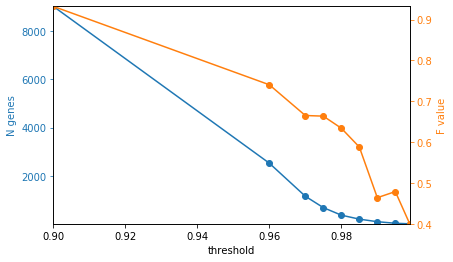

In [33]:
summary_no_log=neighbour_calculator.plot_select_threshold(thresholds=[0.9,0.96,0.97,0.975,0.98,0.985,0.99,
                                                                      0.995,0.999],
                                                   filter_column='Replicate',
                                                   filter_column_values_sub=subset1,
                                                   filter_column_values_test=subset2,
                                                   neighbours_n=2,use_log=False)

In [55]:
summary_no_log.loc[:,['threshold','N genes','F value']]

,threshold,N genes,F value
0,0.900,9017,0.932247
1,0.960,2523,0.740310
2,0.970,1154,0.665054
3,0.975,683,0.663551
4,0.980,371,0.633971
5,0.985,206,0.587973
6,0.990,100,0.463918
7,0.995,35,0.478873
8,0.999,13,0.400000


Scaling with mean0std1 and log transformation.

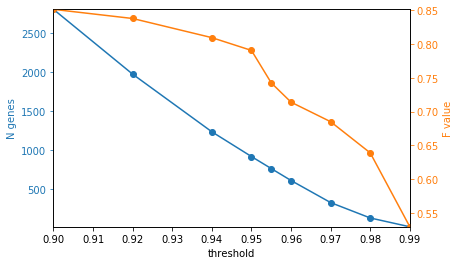

In [44]:
summary_meanstd=neighbour_calculator.plot_select_threshold(thresholds=[0.9,0.92,0.94,0.95,0.955,0.96,0.97,0.98,0.99],
                                                   filter_column='Replicate',
                                                   filter_column_values_sub=subset1,
                                                   filter_column_values_test=subset2,
                                                   neighbours_n=2,scale='mean0std1')

In [56]:
summary_meanstd.loc[:,['threshold','N genes','F value']]

,threshold,N genes,F value
0,0.900,2803,0.851515
1,0.920,1973,0.837980
2,0.940,1235,0.809626
3,0.950,918,0.790698
4,0.955,764,0.742610
5,0.960,611,0.714022
6,0.970,328,0.685083
7,0.980,131,0.638889
8,0.990,18,0.529412


# Conclusion

Based on above tests the genes for regulon (non inverse) calculation could be obtained with: 2 closest neighbours calculation based on cosine similarity and data preprocessed with log transformation and mean 0 and std 1 scaling. Threshold for inclusion of genes in close neighbours pairs could be 0.95 (or above): retaining approx 1000 genes (or less).